In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

product_name_trans = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\product_category_name_translation.csv")
seller = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_sellers_dataset.csv")
products = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_products_dataset.csv")
orders = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_orders_dataset.csv")
order_reviews = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_order_reviews_dataset.csv")
order_payments = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_order_payments_dataset.csv")
order_items = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_order_items_dataset.csv")
geolocation = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_geolocation_dataset.csv")
customers = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_customers_dataset.csv") 

The data is duplicated in some files. For example, in **order_reviews** we have duplicated items in *order_id* column (i.e. customers can write reviews for several items of one order). Therefore, we should be careful before merging the files.

In [119]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_status                     99441 non-null object
order_purchase_timestamp         99441 non-null object
order_approved_at                99281 non-null object
order_delivered_carrier_date     97658 non-null object
order_delivered_customer_date    96476 non-null object
order_estimated_delivery_date    99441 non-null object
dtypes: object(8)
memory usage: 6.1+ MB


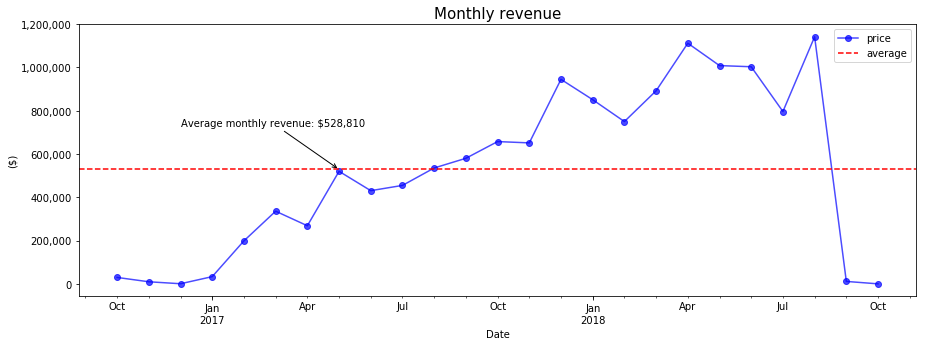

In [161]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#Merging 2 dataframe orders and order_items 
data = orders.merge(order_items, left_on = 'order_id', right_on = 'order_id', how ='left', indicator = True)
data['order_delivered_customer_date'] = pd.to_datetime(data.order_delivered_customer_date)

#What is company total revenue ?
data1 = data[~data.order_delivered_customer_date.isna()]\
             .rename(columns = {'order_delivered_customer_date':'Date'}).set_index('Date')

data_revenue_monthly = data1.query('order_status == "delivered"').resample('M').agg({'price':'sum'})
avg_revenue_monthly = data_revenue_monthly.price.mean()

ax = data_revenue_monthly.plot(figsize = (15,5), style = 'bo-', label ='Revenue', alpha = 0.7)
plt.title('Monthly revenue', fontsize =15)
plt.axhline(avg_revenue_monthly, color ='r', linestyle ='--', label = 'average')
plt.legend()
plt.ylabel('($)')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.annotate(f'Average monthly revenue: ${avg_revenue_monthly:,.0f}', xy = ('2017-05-01', avg_revenue_monthly)\
             , xytext = ('2016-12-01', avg_revenue_monthly + 200000), arrowprops = dict(arrowstyle = '->'))
plt.show()